# Make polygons of the different regions and find the points within the regions


In [181]:
from shapely import geometry
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import geopandas as gpd
from pyproj import CRS
import xarray as xr
import numpy as np

In [182]:
import pandas as pd
from shapely.geometry import Point, Polygon


Make a function that reads in regions and convert them to a geopandas dataframe

In [189]:
beaufortLons = [-156.65,-156.48,-112.34,-124.58,-124]
beaufortLats = [65.37,80,77.69,75.67,65]

cLons = [-156.65,-180,-180,-156.48]
cLats = [65.37,66,80,80]

esLons = [145,145,-180,-180]
esLats = [65,80,80,66]

In [233]:
def createRegionGeometries(lons,lats,name): 
    '''
    reads in lons and lats from a list (the vertices of the polygon) and a name to give to the polygon
    and returns a geopandas dataframe with the polygon of the region
    '''
    polygon_geom = geometry.Polygon(zip(lons, lats))
    crs = CRS('epsg:4326') #need a projection for the datavframe
    polygon = gpd.GeoDataFrame({'region': [name], 'geometry': polygon_geom}, crs=crs)       
    return polygon

beaufort = createRegionGeometries(beaufortLons,beaufortLats,name='Beaufort')
c = createRegionGeometries(cLons,cLats,name='chukhci')
ES = createRegionGeometries(esLons,esLats,name='East Siberian')

## Plot the regions on a map

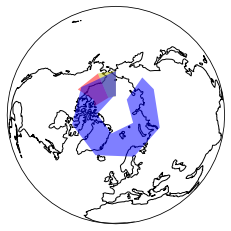

In [234]:
fig,ax = plt.subplots(subplot_kw={'projection':ccrs.Orthographic(central_latitude=90)})
ax.coastlines()

for region,color in zip([beaufort,c,ES],['r','y','b']): 

    ax.add_geometries(region.geometry, 
                      crs = ccrs.PlateCarree(),
                      alpha=0.5,
                      facecolor=color)
# for Lat/Lon data.

## Find whether points are in a region
* we load a dummy xarray dataset

In [197]:
dummyData = xr.DataArray(data=np.random.rand(180,360),
                         dims = ['latitude','longitude'],
                      coords = {
                          'latitude' : np.arange(-90,90),
                          'longitude' : np.arange(-180,180)
                      })

In [198]:
def grid_regions(da,regions):
    '''
    This function checks if whether a point is within a region or not.
    A point is here lat and lon from da

    It returns the number of the region if the point is within that region.

    Input
    -------
    da : xarray dataset with lats lons
    
    
    
    Returns
    -------
    grid_xr: dataset (xarray) with grid_region as one of the variables on the lat lon grid

    '''
    grid_region = np.ones((da.latitude.size,da.longitude.size))*np.nan

    for rr in range(len(regions)):
        region =  regions.loc[rr].geometry

        for yy,lat in enumerate(da.latitude.values):
            for xx,lon in enumerate(da.longitude.values):
                p_ = Point(lon,lat)

                a = region.contains(p_)
                if a:
                    grid_region[yy,xx] = rr


    grid_xr = xr.Dataset({'grid_region':(['latitude','longitude'],grid_region)},
                          coords={'latitude': da.latitude,
                                'longitude': da.longitude})
    return grid_xr



In [240]:
a = xr.merge([grid_regions(dummyData,ES),dummyData.to_dataset(name='dummy')])

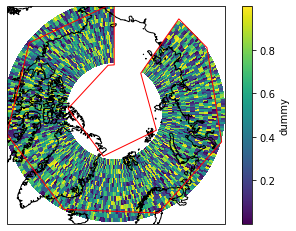

In [241]:
fig,ax = plt.subplots(subplot_kw={'projection':ccrs.Orthographic(central_latitude=90)})
ax.coastlines()
ax.add_geometries(ES.geometry, crs = ccrs.PlateCarree(),edgecolor='red',facecolor=
                 'none') # for Lat/Lon data.
ax.pcolormesh(a.where(a.grid_region==0).dummy,transform=ccrs.PlateCarree(),cmap='magma')
a.where(a.grid_region==0).dummy.plot(ax=ax,transform=ccrs.PlateCarree())
ax.set_extent([0.5,359.9,65,90],crs=ccrs.PlateCarree())